In [1]:
from pangal.spectrum import Spectrum
from pangal.photometry_table import PhotometryTable
from pangal.model_builders.simple_cigale import make_cigale_models, load_spectrum_models_from_fits

from pangal.filter import list_filters,list_hst_filters

#from pangal.model_builders.boissier import M, Md, Rd, Sigma_0, surface_density, Vc_to_Md, Md_to_Vc, Rc, rho_0, velocity_profile, boissier_unperturbed, boissier_quenched

import warnings
warnings.simplefilter("ignore")



ModuleNotFoundError: No module named 'pcigale'

In [ ]:
import numpy as np
import astropy
from bisect import bisect_left
from scipy.special import erf
from scipy.interpolate import RegularGridInterpolator, interp1d
import itertools
import os

from dynesty import NestedSampler
from dynesty import plotting as dyplot
from dynesty.utils import resample_equal
import corner

import sys, os
sys.path.append(os.path.expanduser('~/Desktop/Pangal'))

from pangal.image import Image
#from pangal.spectrum import Spectrum
from pangal.filter import Filter, map_filter_names, nice_filter_names, default_plot_scale_lims, default_plot_units, default_cmaps
from pangal.pfitter_utils import load_dust_emission_models, load_nebular_tables, model_grid_interpolator, dust_attenuation_curve
from scipy.integrate import quad

from astropy.io import fits


class PFitter(): # Parametric fitter

    def __init__(self, model_list, model_pars, cosmo=None, dustemimodel='dh02', leitatt=True, uv_bump=True, emimetal=0.0017, emimodel='2018'):

        self.model_pars = model_pars  # list the variables defyning the model grid
        print(f"Initializing PFitter object")
        print(f"   Model parameters: {', '.join(self.model_pars)}\n")

        # Menages model grid
        if not isinstance(model_list, list):
            raise ValueError("Error: model_grid is not a numpy array.")

        self.interp_young_flux, self.interp_old_flux, self.model_pars_arr, self.short_model_wl  = self.model_grid_interpolator(model_list, self.model_pars)

        print(f" Pre-computed model grid:")
        for name, arr in zip(self.model_pars, self.model_pars_arr):
            print(f"   - {name}: {len(arr)} values, min={arr[0]}, max={arr[-1]}")
        print("\n")
        
        #get the wavelength information for the dust templates to stitch it to the stellar model wl 
        #this_dir = os.path.dirname(os.path.abspath(__file__))
        #file_path = os.path.join(this_dir, 'data', f'spectra_{dustemimodel}.dat')
        file_path = '/home/utente/Desktop/Pangal/pangal/data/'+f'spectra_{dustemimodel}.dat'
        dust_wl = np.loadtxt(file_path, usecols=(0,)) * 1e4   # Load wavelength grid (in Angstroms)

        #expand wavelength grid to include range covered by dust templates
        # Find the extended part of dust_wl
        extra_wl_mask = dust_wl > self.short_model_wl.max()
        extra_wl = dust_wl[extra_wl_mask]

        # Extend wavelength grid
        self.model_wl = np.r_[self.short_model_wl, extra_wl]

        # Extend resolution array with constant value matching the number of extra wavelengths
        last_res = model_list[0].resolution[-1]
        extra_res = np.full(extra_wl.size, last_res)

        # Concatenate the original model resolution with the extended constant resolution
        self.model_res = np.r_[model_list[0].resolution, extra_res]

        # PRECOMPUTES DUST ATTENUATION CURVE (Calzetti, 2000 + optional Leitherer+2002 + optional UV bump)
        self.k_cal = dust_attenuation_curve(self.model_wl, leitatt, uv_bump)

        # LOADS NEBULAR LINE TABLES
        self.nebular_func, self.nebular_ions, self.nebular_ages = self.load_nebular_tables(self.model_wl,self.model_res, emimetal,emimodel)

        # LOADS DUST EMISSION SPECTRA
        # This can be moved above for computing dust_wl only once?
        self.dustem_func, self.dustem_alpha = self.load_dust_emission_models(self.model_wl,dustemimodel)



    # methods

    load_nebular_tables = load_nebular_tables
    load_dust_emission_models = load_dust_emission_models
    dust_attenuation_curve = dust_attenuation_curve
    model_grid_interpolator = model_grid_interpolator


    
    def run_fit(self,
            
        spec= None,
        phot= None,

        bands= None,          # if I want to use only some of the bands in phot dict

        fix_pars={},          # dictionary 
        custom_priors={},        # dictionary

        polymax = 7,    

        nlive = 500,
        dlogz = 0.01,

        ):

        # Filter bands to only those present in map_filter_names
        if bands: 
            for b in bands:
                if b not in map_filter_names.keys():
                    raise ValueError(f'Unrecognized filter: {b}. Abort')
            self.bands = bands
        else:
            self.bands = [b for b in phot.photometry.keys() if b in map_filter_names.keys()]
        # Print which filters are used
        print(f"Using the following photometric filters: {', '.join(self.bands)}")
        

        # Redshift and luminosity distance
        if phot and hasattr(phot, 'header') and 'redshift' in phot.header:
            self.redshift = phot.header['redshift']
        elif spec and hasattr(spec, 'header') and 'redshift' in spec.header:
            self.redshift = spec.header['redshift']
        else:
            print("Redshift not provided and not found in phot dictionary or spectrum header. Set to 0.")
            self.redshift = 0
       
        #Derive luminosity distance in Mpc
        if phot and 'dl' in phot.header.keys():
            self.dl = phot.header['dl']
        elif spec and hasattr(spec, 'header') and 'dl' in spec.header:
            self.dl = spec.header['dl']
        else:
            from astropy.cosmology import FlatLambdaCDM
            cosmo = FlatLambdaCDM(H0=70,Om0=0.3)        
            self.dl = cosmo.luminosity_distance(self.redshift).value


        
        # Handles PARAMETERS: removes fixed parameters
        self.fix_pars = fix_pars
        free_pars = [p for p in self.model_pars + ["fesc", "ion_gas", "age_gas", "av", "av_ext", "alpha", "m_star"]
                     if p not in self.fix_pars]
        self.free_pars = free_pars
        
        # Create the sampler
        log_likelihood = self.make_log_likelihood(spec, phot, free_pars, bands)
        prior_transform = self.make_prior_transform(custom_priors)

        print("Initializing live points")
        sampler = NestedSampler(log_likelihood, prior_transform, ndim=len(free_pars),nlive=100) #self.nlive

        # Run the nested sampling
        sampler.run_nested(dlogz=dlogz, print_progress=True)

        # Access results
        res = sampler.results

        # safe to save internally the result
        self.fit = res

        return res

    
    def make_log_likelihood(self, spec, phot, free_pars, bands):

        # --- Precompute constants ---
        if spec:
            print("Fitting spectrum")
    
        if phot:
            # Convert PhotometryTable object into arrays
            phot_points = np.array([phot.data[b][0] for b in bands])
            phot_errors = np.array([phot.data[b][1] for b in bands])
            upper_lims = (phot_points / phot_errors < 5).astype(int)
    
            # Precompute filter transmission curves on the model wavelength grid
            mask = {}
            trans_arrays = {}
            pivot_wls = {}
            for b in bands:
                F = Filter(b)
                lmin, lmax = F.wavelength_range
                mask[b] = (self.model_wl >= lmin) & (self.model_wl <= lmax)
                trans_arrays[b] = F.transmission_curve(self.model_wl[mask[b]])
                pivot_wls[b] = F.pivot_wavelength
    
        # --- Define log-likelihood ---
        def log_likelihood(pars):
            
            spec_lhood = 0
            phot_lhood = 0


            if spec: 

                
            
            if phot:
                idx = 0
                n_model_pars = len(self.model_pars)
                model_pars = pars[idx : idx + n_model_pars]
                idx += n_model_pars
    
                param_names = ["fesc", "ion_gas", "age_gas", "av", "av_ext", "alpha", "m_star"]
                param_values = {}
                for name in param_names:
                    if name in self.fix_pars:
                        param_values[name] = self.fix_pars[name]
                    else:
                        param_values[name] = pars[idx]
                        idx += 1
    
                fesc, ion_gas, age_gas, av, av_ext, alpha, m_star = [param_values[n] for n in param_names]
                kwargs = {key: value for key, value in zip(self.model_pars, model_pars)}
    
                # Build synthetic spectrum
                synth_spec = self.synthetic_spectrum(**kwargs,
                                                     fesc=fesc, ion_gas=ion_gas, age_gas=age_gas,
                                                     av=av, av_ext=av_ext, alpha=alpha,
                                                     m_star=m_star, redshift=0, dl=100)
    
                model_phot = []
                for b in bands:
                    spec_array = synth_spec.flux[mask[b]]
                    if len(spec_array) == 0:
                        model_phot.append(np.nan)
                        continue
    
                    num_int = np.trapz(trans_arrays[b] * spec_array, self.model_wl[mask[b]])
                    norm_int = np.trapz(trans_arrays[b], self.model_wl[mask[b]])
                    if norm_int == 0:
                        model_phot.append(np.nan)
                        continue
    
                    phot_point = num_int / norm_int

                    # CHECK THIS
                    # Convert to mJy if needed
                    c = 2.99792458e18  # Å/s
                    phot_point = phot_point * pivot_wls[b]**2 / c / 1e-26
    
                    model_phot.append(phot_point)
    
                model_phot = np.array(model_phot)
    
                if not np.all(np.isfinite(model_phot)):
                    return -1e100
    
                for i in range(len(phot_points)):
                    if upper_lims[i] == 0:
                        phot_lhood += -0.5 * (
                            (phot_points[i] - model_phot[i])**2 / phot_errors[i]**2
                            + np.log(phot_errors[i]**2)
                            + np.log(2. * np.pi)
                        )
                    else:
                        terf = 0.5 * (1 + erf((phot_points[i] - model_phot[i]) /
                                              (np.sqrt(2.) * phot_errors[i])))
                        phot_lhood += np.log(terf)
    
            if not np.isfinite(phot_lhood):
                return -1e100
            
            return spec_lhood + phot_lhood

            
    
        return log_likelihood
    
    
    def make_prior_transform(self, custom_priors):

        # --- Validate custom priors ---
        all_pars = list(self.model_pars) + [
            p for p in ["fesc", "ion_gas", "age_gas", "av", "av_ext", "alpha", "m_star"]
            if p not in self.fix_pars
        ]
        for key, val in custom_priors.items():
            if key not in all_pars:
                raise ValueError(f"Unknown parameter in prior_dict: '{key}'. Valid names: {all_pars}")
            if 'type' not in val:
                raise ValueError(f"Missing 'type' field for prior '{key}'. Must be 'uniform' or 'gaussian'.")
            if val['type'] == 'uniform' and not all(k in val for k in ['low', 'high']):
                raise ValueError(f"Uniform prior '{key}' must define 'low' and 'high'.")
            if val['type'] == 'gaussian' and not all(k in val for k in ['mean', 'sigma']):
                raise ValueError(f"Gaussian prior '{key}' must define 'mean' and 'sigma'.")

        # --- Default priors ---
        priors = {
            'fesc':    {'type': 'uniform', 'low': 0.0, 'high': 1.0},
            'ion_gas': {'type': 'uniform', 'low': self.nebular_ions[0], 'high': self.nebular_ions[-1]},
            'age_gas': {'type': 'uniform', 'low': self.nebular_ages[0], 'high': self.nebular_ages[-1] + 1},
            'av':      {'type': 'uniform', 'low': 0.0, 'high': 1.0},
            'av_ext':  {'type': 'uniform', 'low': 0.0, 'high': 1.0},
            'alpha':   {'type': 'uniform', 'low': self.dustem_alpha[0], 'high': self.dustem_alpha[-1]},
            'm_star':  {'type': 'uniform', 'low': 7.0, 'high': 11.0}
        }
        for i, p in enumerate(self.model_pars):
            lo, hi = self.model_pars_arr[i][0], self.model_pars_arr[i][-1]
            priors[p] = {'type': 'uniform', 'low': lo, 'high': hi}

        # --- Override with user-defined priors ---
        for p in custom_priors.keys():
            priors[p] = custom_priors[p]

        # --- Print priors ---
        print("\nPriors:")
        for p in all_pars:
            if priors[p]['type'] == 'uniform':
                print(f"  - {p}: Uniform({priors[p]['low']}, {priors[p]['high']})")
            elif priors[p]['type'] == 'gaussian':
                print(f"  - {p}: Gaussian(mean={priors[p]['mean']}, sigma={priors[p]['sigma']})")
            else:
                print(f"  - {p}: {priors[p]['type']}")

        # --- Define transform function based on priors ---
        def prior_transform(u):
            x = np.zeros_like(u)
            for i, name in enumerate(all_pars):
                prior = priors[name]
                if prior['type'] == 'uniform':
                    x[i] = prior['low'] + u[i] * (prior['high'] - prior['low'])
                elif prior['type'] == 'gaussian':
                    # Use inverse CDF of normal distribution
                    x[i] = prior['mean'] + prior['sigma'] * np.sqrt(2) * erfinv(2 * u[i] - 1)
                else:
                    raise ValueError(f"Unsupported prior type '{prior['type']}' for parameter '{name}'.")
            return x

        return prior_transform





    

    def synthetic_spectrum(self, fesc, ion_gas, age_gas, av, av_ext, alpha, m_star, redshift, dl, multi_component=False, **kwargs,):
        """
        Generate a physically motivated synthetic galaxy spectrum, combining stellar populations, nebular lines, 
        dust attenuation, and re-emission, redshifted and scaled for observational comparison.

        Parameters
        ----------
        fesc : float
            Escape fraction of ionizing photons (0 = fully absorbed by gas; 1 = no nebular emission).
        
        ion_gas : float
            Ionization parameter of the nebular gas.

        age_gas : float
            Age of the nebular region in Myr (affects emission line spectrum).

        av : float
            V-band attenuation for the old stellar population (in magnitudes).

        av_ext : float
            Extra V-band attenuation applied only to the young stellar population.

        alpha : float
            Parameter controlling the shape of the dust emission SED (Dale & Helou 2002 models).

        m_star : float
            Logarithmic stellar mass of the galaxy (in solar masses, log₁₀[M*/M☉]).

        redshift : float
            Redshift of the galaxy.

        dl : float
            Luminosity distance to the galaxy in parsecs (used for flux scaling).

        multi_component : bool, optional
            If True, returns sub-components (e.g., dust, young/old spectra) in the output Spectrum object for inspection or plotting.

        **kwargs :
            Passed to stellar population model interpolators (e.g., age, metallicity, SFH parameters).

        Returns
        -------
        Spectrum
            A synthetic `Spectrum` object with:
                - wavelength grid in observed frame (Angstrom),
                - flux in erg/s/cm²/Å,
                - optional components if `multi_component=True` (e.g., dust emission, attenuated spectra).

        Notes
        -----
        The returned spectrum is built in the following order:
        1. Interpolate young and old stellar templates on model grid.
        2. Compute ionizing photon rates to scale nebular emission.
        3. Add nebular emission lines based on gas parameters and fesc.
        4. Apply dust attenuation using a Calzetti-like law.
        5. Compute energy absorbed by dust and add thermal IR emission from templates.
        6. Apply redshifting and flux scaling for observer's frame.

        The resulting spectrum is suitable for SED fitting, photometry synthesis, or mock observation generation.
        """
        
        young_stellar_spec = self.interp_young_flux(**kwargs)
        old_stellar_spec = self.interp_old_flux(**kwargs)

        # Resample the flux from short_wl to model_wl
        young_stellar_spec = np.interp(self.model_wl, self.short_model_wl, young_stellar_spec)
        old_stellar_spec = np.interp(self.model_wl, self.short_model_wl, old_stellar_spec)


        # Number of lyman continuum photons
        # Spectra are corrected for lyman continuum absorption including escape fraction

        #get number of lyman continuum photons from the young stellar population and the old stellar population
        #spec in erg/s/cm2/A so it returns the flux of ionizing photons not the rate 
        index_lyman = np.searchsorted(self.model_wl, 912, side='left') #wavelength just above Lyman limit

        lycont_wls = np.r_[self.model_wl[:index_lyman], np.array([912])]

        lycont_spec = np.interp(lycont_wls, self.model_wl, young_stellar_spec) 
        
        nlyman_young = np.trapz(lycont_spec*lycont_wls, lycont_wls)/6.626e-27/2.998e18 * (1-fesc)

        lycont_spec = np.interp(lycont_wls, self.model_wl, old_stellar_spec)                        # WHY THIS? WHAT CHANGES?
        nlyman_old = np.trapz(lycont_spec*lycont_wls, lycont_wls)/6.626e-27/2.998e18 * (1-fesc)

        #modify input spec to remove photons 
        if fesc>=0:
            young_stellar_spec[:index_lyman] *= fesc
            old_stellar_spec[:index_lyman] *= fesc             # is this necessary ?? 

        nebular_lines = self.nebular_func(ion_gas,age_gas) 

        # to get the full spec normalized line spectra must be multiplied by the un-escaped number of lyman photons from the stellar model
        nebular_young = nebular_lines * nlyman_young 
        nebular_old = nebular_lines * nlyman_old

        young_stellar_nebular_spec = young_stellar_spec + nebular_young
        old_stellar_nebular_spec = old_stellar_spec + nebular_old
        stellar_nebular_spec = young_stellar_nebular_spec + old_stellar_nebular_spec

        # Dust attenuation

        #attenuate photometry spec, k_cal is precomputed in the rest frame as it should be
        att_young_stellar_nebular_spec = (10**(-(av+av_ext)*self.k_cal) * (young_stellar_nebular_spec))
        att_old_stellar_nebular_spec   = (10**(-av*self.k_cal) * (old_stellar_nebular_spec))
        att_stellar_nebular_spec  = att_young_stellar_nebular_spec + att_old_stellar_nebular_spec


        #### THERMAL DUST EMISSION ####
        lbol_init = np.trapz(stellar_nebular_spec, self.model_wl)
        lbol_att  = np.trapz(att_stellar_nebular_spec, self.model_wl)

        dust_bol = (lbol_init - lbol_att)
        
        # raw interpolated dust emission template. independent of your specific galaxy model. 
        # generic spec for a given α (which controls dust heating intensity).

        tdust_spec = self.dustem_func(alpha)

        # remove stellar component which is included in dale models
        # otherwise it is double-counted.
        mask_pixels = (self.model_wl >= 2.5e4) & (self.model_wl <= 3e4)
        scale = np.sum(stellar_nebular_spec[mask_pixels]*tdust_spec[mask_pixels]) / np.sum(stellar_nebular_spec[mask_pixels]*stellar_nebular_spec[mask_pixels])
        tdust_spec -= scale*stellar_nebular_spec
        tdust_spec[(self.model_wl < 2.5e4) | (tdust_spec < 0.)] = 0.

        # scale to the correct total energy to re-emit
        norm = np.trapz(tdust_spec, self.model_wl)     
        dust_spec = tdust_spec * dust_bol / norm

        total_spec = att_stellar_nebular_spec + dust_spec

        # move to the observed frame
        model_red_wl = self.model_wl * (1+redshift)
        total_spec /= (1+redshift)

        # this models are scaled to 1 solar mass at 10 pc
        # Rescale
        fscale = 10**m_star / (dl * 1e5)**2

        total_spec *= fscale 

        header = fits.Header()
        header['WUNITS'] = 'A'                
        header['FUNITS'] = 'erg/s/cm2/A'   

        spec = Spectrum(wl=model_red_wl,resolution=self.model_res,flux=total_spec,header=header)

        if multi_component:
            # arrays usefull for plotting
            for s in [young_stellar_nebular_spec, old_stellar_nebular_spec, att_young_stellar_nebular_spec, att_old_stellar_nebular_spec, dust_spec]:
                s /= (1+redshift)
                s *= fscale 
            spec.young_stellar_nebular = young_stellar_nebular_spec
            spec.old_stellar_nebular = old_stellar_nebular_spec
            spec.att_young_stellar_nebular = att_young_stellar_nebular_spec
            spec.att_old_stellar_nebular = att_old_stellar_nebular_spec
            spec.dust = dust_spec

        return spec
    

    def cornerplot(self, fit_result, show_stats=True, cmap='viridis', alpha=0.7,):
        """
        Make a corner plot from Dynesty fit results.
    
        Parameters
        ----------
        fit_result : dynesty results object
            The nested sampling results.
        show_stats : bool
            Whether to display mean ± std on top of histograms.
        cmap : str
            Matplotlib colormap for 2D contours.
        alpha : float
            Transparency for 2D contour fills.
        """    
        #resample 
        samples, weights = fit_result.samples, np.exp(fit_result.logwt - fit_result.logz[-1])
        equal_samples = resample_equal(samples, weights)
    
        # Map parameter names to nicer LaTeX labels
        latex_labels = {
            "age": r"$\mathrm{Age~[Myr]}$",
            "tau_main": r"$\tau_\mathrm{main} \mathrm{~[Myr]}$",
            "age_trunc": r"$Q_\\text{AGE}\mathrm{~[Myr]}$",
            "tau_trunc": r"$\\tau_\\text{Q}\mathrm{~[Myr]}$",
            "fesc": r"$f_\mathrm{esc}$",
            "ion_gas": r"$U_\mathrm{ion}$",
            "age_gas": r"$\mathrm{Age_{gas}}$",
            "av": r"$A_V$",
            "av_ext": r"$A_{V,ext}$",
            "alpha": r"$\alpha$",
            "m_star": r"$\log(M_\star)$"
        }
        labels = [latex_labels.get(p, p) for p in self.free_pars]
    
        plt.close('all')
        fig = corner.corner(equal_samples, labels=self.free_pars,
                    color='k', plot_contours=True, fill_contours=True,
                    cmap=cmap, alpha=alpha)
        
        if show_stats:
            means = np.mean(equal_samples, axis=0)
            stds = np.std(equal_samples, axis=0)
            # corner creates n*n axes, diagonal axes are at positions 0, n+1, 2*(n+1), ...
            diag_axes = [fig.axes[i*(len(self.free_pars)+1)] for i in range(len(self.free_pars))]
            for i, ax in enumerate(diag_axes):
                ax.set_title(f"{means[i]:.3f} ± {stds[i]:.3f}", fontsize=10, pad=12)
    
        plt.show()
    


In [41]:
from pangal.photometry_table import PhotometryTable, fits_to_PhotometryTable, print_photometric_tables

In [42]:
#phot_table = fits_to_PhotometryTable('some_data/photometry_tables_NGC4848.fits')

In [43]:
#print_photometric_tables(phot_table)

In [6]:
specs = load_spectrum_models_from_fits('some_data/simple_cigale_sfh2exp')

In [7]:
print(specs[0].header)

XTENSION= 'BINTABLE'           / binary table extension                         BITPIX  =                    8 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                   12 / length of dimension 1                          NAXIS2  =                16688 / length of dimension 2                          PCOUNT  =                    0 / number of group parameters                     GCOUNT  =                    1 / number of groups                               TFIELDS =                    3 / number of table fields                         TTYPE1  = 'FLUX    '                                                            TFORM1  = 'E       '                                                            TTYPE2  = 'FLUX_YOUNG'                                                          TFORM2  = 'E       '                                                            TTYPE3  = 'FLUX_OLD'                    

In [8]:
specs[0].flux_young

array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 1.2824240e-22,
       9.9832083e-23, 6.9905584e-23], dtype='>f4')

In [9]:
specs[0].get_phot(bands=['sdss_u','sdss_r']).print

,Value,Error,SNR
Band,,,
sdss_u,1.130599e-13,NaN,NaN
sdss_r,4.404126e-14,NaN,NaN


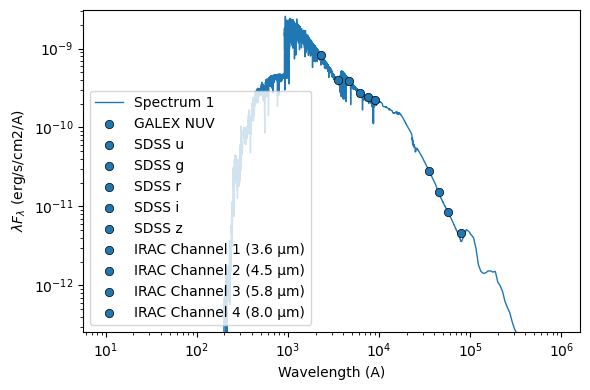

In [11]:
specs[0].plot(per_wavelength=True,phot_points=['galex_nuv','sdss_u','sdss_g','sdss_r','sdss_i','sdss_z',
                                                     'spitzer_irac_1','spitzer_irac_2','spitzer_irac_3','spitzer_irac_4'])

In [348]:
#for s in spec:
#    s.plot(show_spectral_lines=False,log=True,per_wavelength=True,bands=['sdss_u','sdss_r'],)

In [132]:
#spec[0].plot(show_spectral_lines=False,zoom_on_line=['Ha','Hb'],spectra=[spec[0],spec[2],spec[-1]],log=True,ymin=3e-15,ymax=8e-14)  

In [133]:
#spec[0].plot(show_spectral_lines=False,spectra=[spec[0],spec[2],spec[-1]],log=True,per_wavelength=True) 

In [134]:
#spec[2].plot(show_spectral_lines=True,spectra=[spec_models[0],spec_models[10],spec_models[-1]],log=True)

In [123]:
fitter = PFitter(specs,
                 model_pars=['age','tau_main'],
                )

Initializing PFitter object
   Model parameters: age, tau_main

 Pre-computed model grid:
   - age: 5 values, min=100, max=1000
   - tau_main: 3 values, min=100, max=400


Loading nebular lines templates from  nebular_Byler_mist_2018.lines
 Emission line metallicity requested 0.0017, found 0.0020
Tabulated values for ionized gas age (Myr): [ 0.5  1.   2.   3.   4.   5.   6.   7.  10. ]
Tabulated values for ionization coefficient: [-4.  -3.5 -3.  -2.5 -2.  -1.5 -1. ]
Loading of nebular lines templates completed.
Tabulated alpha values from 'alpha_dh02.dat': [0.0625 0.125  0.1875 0.25   0.3125 0.375  0.4375 0.5    0.5625 0.625
 0.6875 0.75   0.8125 0.875  0.9375 1.     1.0625 1.125  1.1875 1.25
 1.3125 1.375  1.4375 1.5    1.5625 1.625  1.6875 1.75   1.8125 1.875
 1.9375 2.     2.0625 2.125  2.1875 2.25   2.3125 2.375  2.4375 2.5
 2.5625 2.625  2.6875 2.75   2.8125 2.875  2.9375 3.     3.0625 3.125
 3.1875 3.25   3.3125 3.375  3.4375 3.5    3.5625 3.625  3.6875 3.75
 3.8125 3.875  3.9375

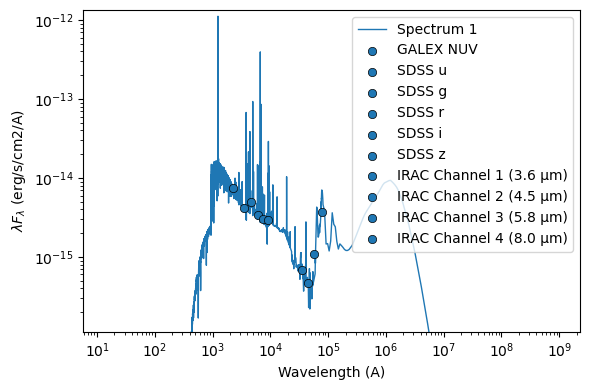

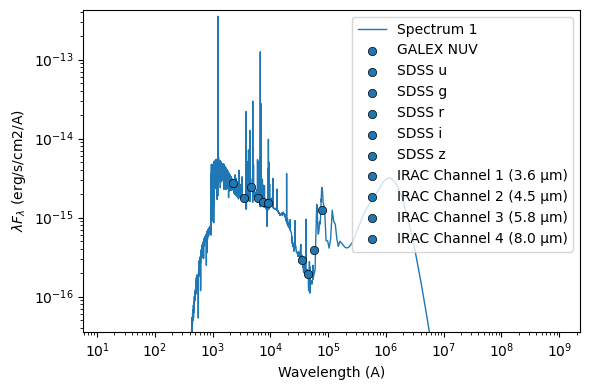

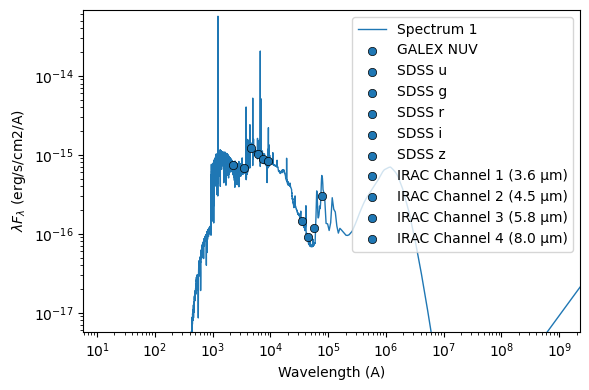

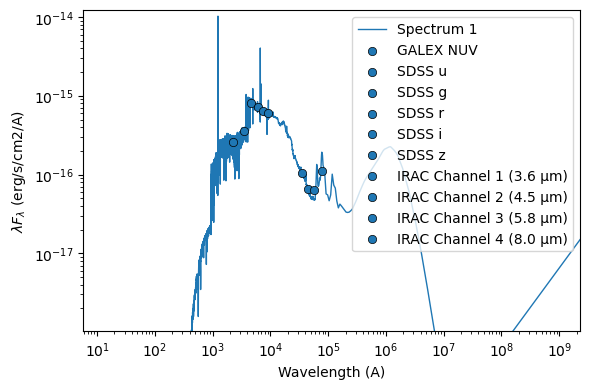

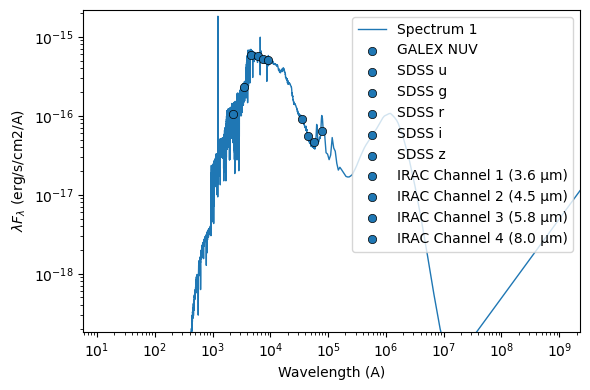

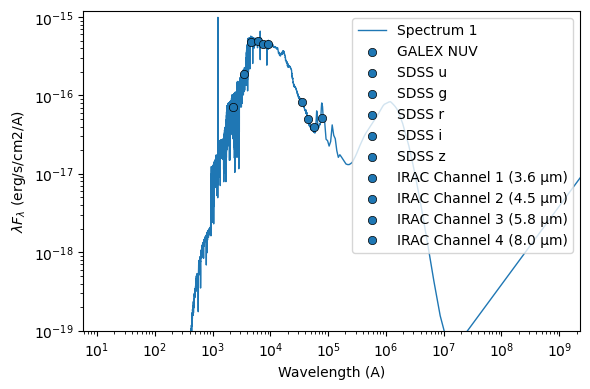

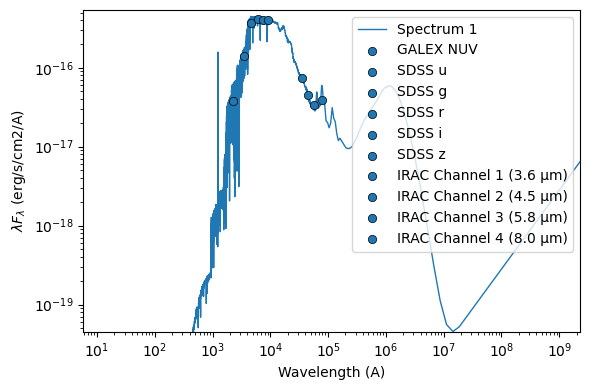

In [67]:

for age in np.linspace(100,1000,7):
    total_spec = fitter.synthetic_spectrum(
            metal=0.017,
            multi_component=True,
            age=age,
            tau_main=100,
            fesc=-0.004,
            av=0.2,
            av_ext= 0.094,
            alpha=2.35,
            m_star=9.2,
            ion_gas=-3.94,
            age_gas=3.997,
            redshift=0.02,
            dl=104,  # Luminosity distance in Mpc (assumed)
        )

       
    total_spec.plot(per_wavelength=True,phot_points=['galex_nuv','sdss_u','sdss_g','sdss_r','sdss_i','sdss_z',
                                                     'spitzer_irac_1','spitzer_irac_2','spitzer_irac_3','spitzer_irac_4'],)

    

In [63]:
mock_spec = fitter.synthetic_spectrum(
            metal=0.017,
            multi_component=True,
            age=102,
            tau_main=100,
            fesc=-0.004,
            av=0.2,
            av_ext= 0.094,
            alpha=2.35,
            m_star=9.2,
            ion_gas=-3.94,
            age_gas=13,
            redshift=0.02,
            dl=104,  # Luminosity distance in Mpc (assumed)
        )



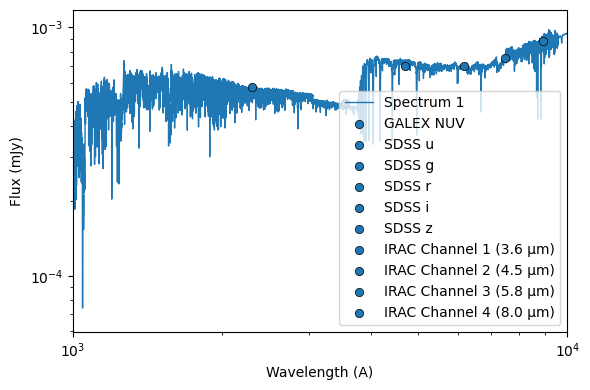

In [34]:
bands=['galex_nuv','sdss_u','sdss_g','sdss_r','sdss_i','sdss_z','spitzer_irac_1','spitzer_irac_2','spitzer_irac_3','spitzer_irac_4']
mock_spec.plot(per_wavelength=False,phot_points=bands,y_units='mJy',x_units='A',
              winf=1000,wsup=1e4) #,ymin=1e-7,ymax=1e-4

phot_points = mock_spec.get_phot(bands=bands,units='mJy')

for b in bands: 
    value, error = phot_points.data[b]
    phot_points.data[b] = (value, 0.1 * value)




In [73]:
phot_points.print

,Value,Error,SNR
Band,,,
galex_nuv,0.000574,0.000057,10.0
sdss_u,0.000495,0.000049,10.0
sdss_g,0.000701,0.000070,10.0
sdss_r,0.000698,0.000070,10.0
sdss_i,0.000751,0.000075,10.0
sdss_z,0.000880,0.000088,10.0
spitzer_irac_1,0.000702,0.000070,10.0
spitzer_irac_2,0.000618,0.000062,10.0
spitzer_irac_3,0.001882,0.000188,10.0


In [116]:
custom_prior = {
    'av':     {'type':'uniform', 'low':0.0,    'high':0.2},
    'alpha':  {'type':'uniform', 'low':1.5,    'high':3.5}
}

In [124]:

results = fitter.run_fit(phot=phot_points, 
                         bands=bands, 
                         fix_pars={'ion_gas':-3.94,'age_gas':13,'fesc':-0.004,'m_star':9.2,'av_ext':0,},
                        nlive=100,
                        dlogz=0.1,
                        custom_priors=custom_prior)

                         #fix_pars={'ion_gas':-3.94,'age_gas':13,'fesc':-0.004,'av':0.2,'av_ext':0.094, 'trunctau':8.202,
                         #          'alpha':2.35,'m_star':9.2,},)


Using the following photometric filters: galex_nuv, sdss_u, sdss_g, sdss_r, sdss_i, sdss_z, spitzer_irac_1, spitzer_irac_2, spitzer_irac_3, spitzer_irac_4
Redshift not provided and not found in phot dictionary or spectrum header. Set to 0.

Priors:
  - age: Uniform(100, 1000)
  - tau_main: Uniform(100, 400)
  - av: Uniform(0.0, 0.2)
  - alpha: Uniform(1.5, 3.5)
Initializing live points


929it [00:21, 43.98it/s, +100 | bound: 19 | nc: 1 | ncall: 6266 | eff(%): 16.688 | loglstar:   -inf < 81.263 <    inf | logz: 74.357 +/-  0.239 | dlogz:  0.001 >  0.100]


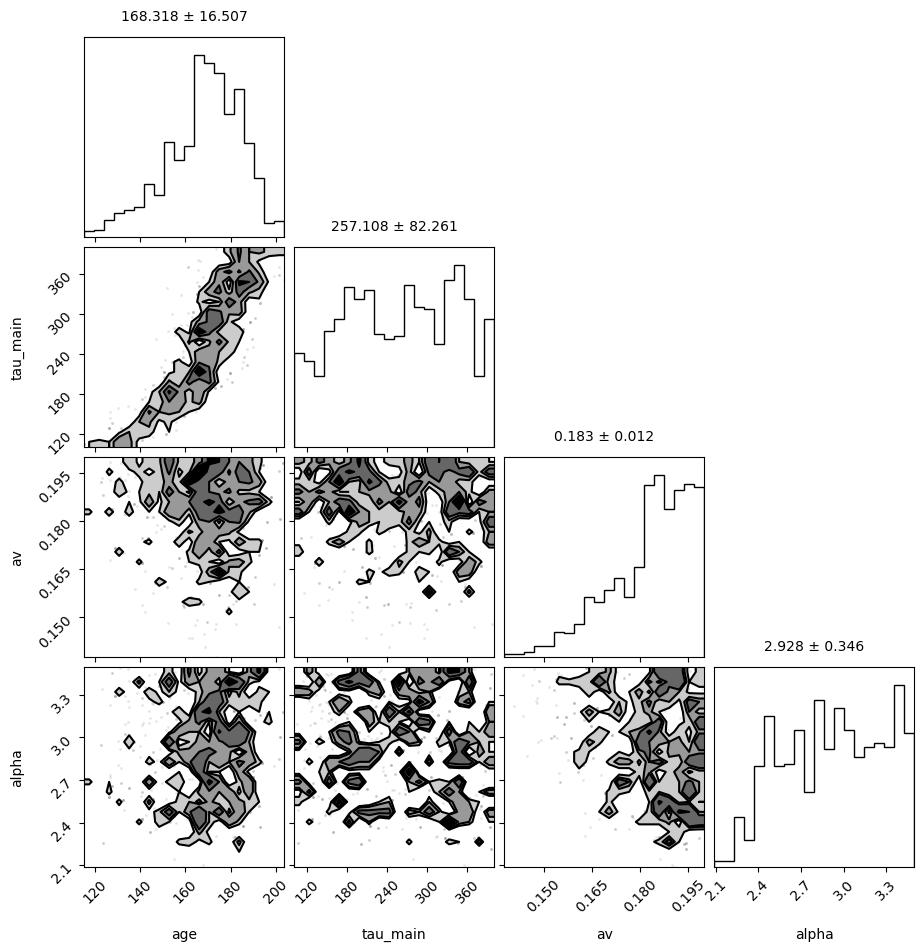

In [127]:
fitter.cornerplot(results, show_stats=True, cmap='Reds', alpha=1,)

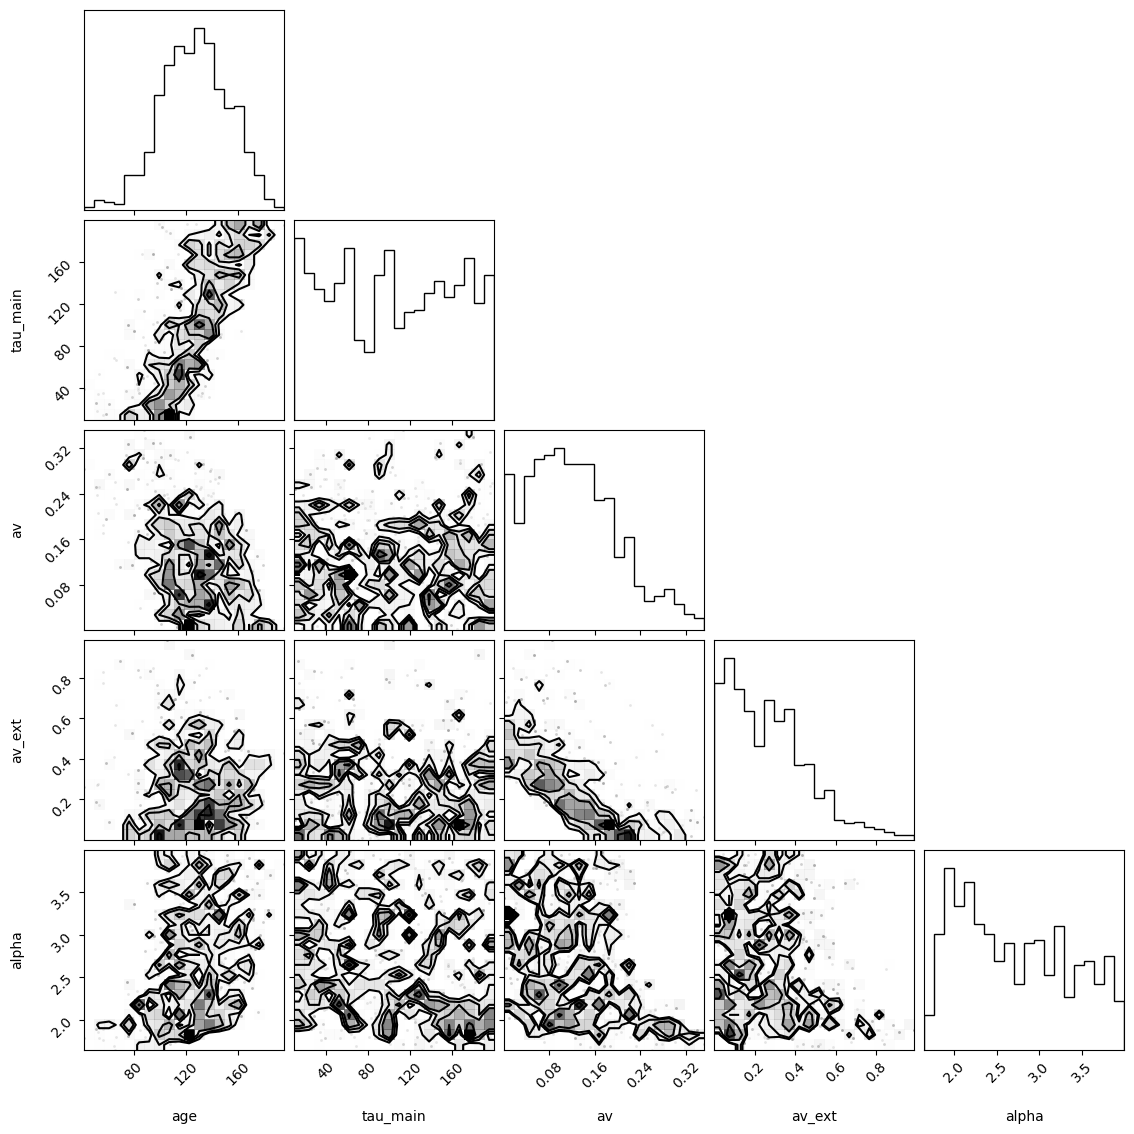

In [54]:
fitter.cornerplot(results)

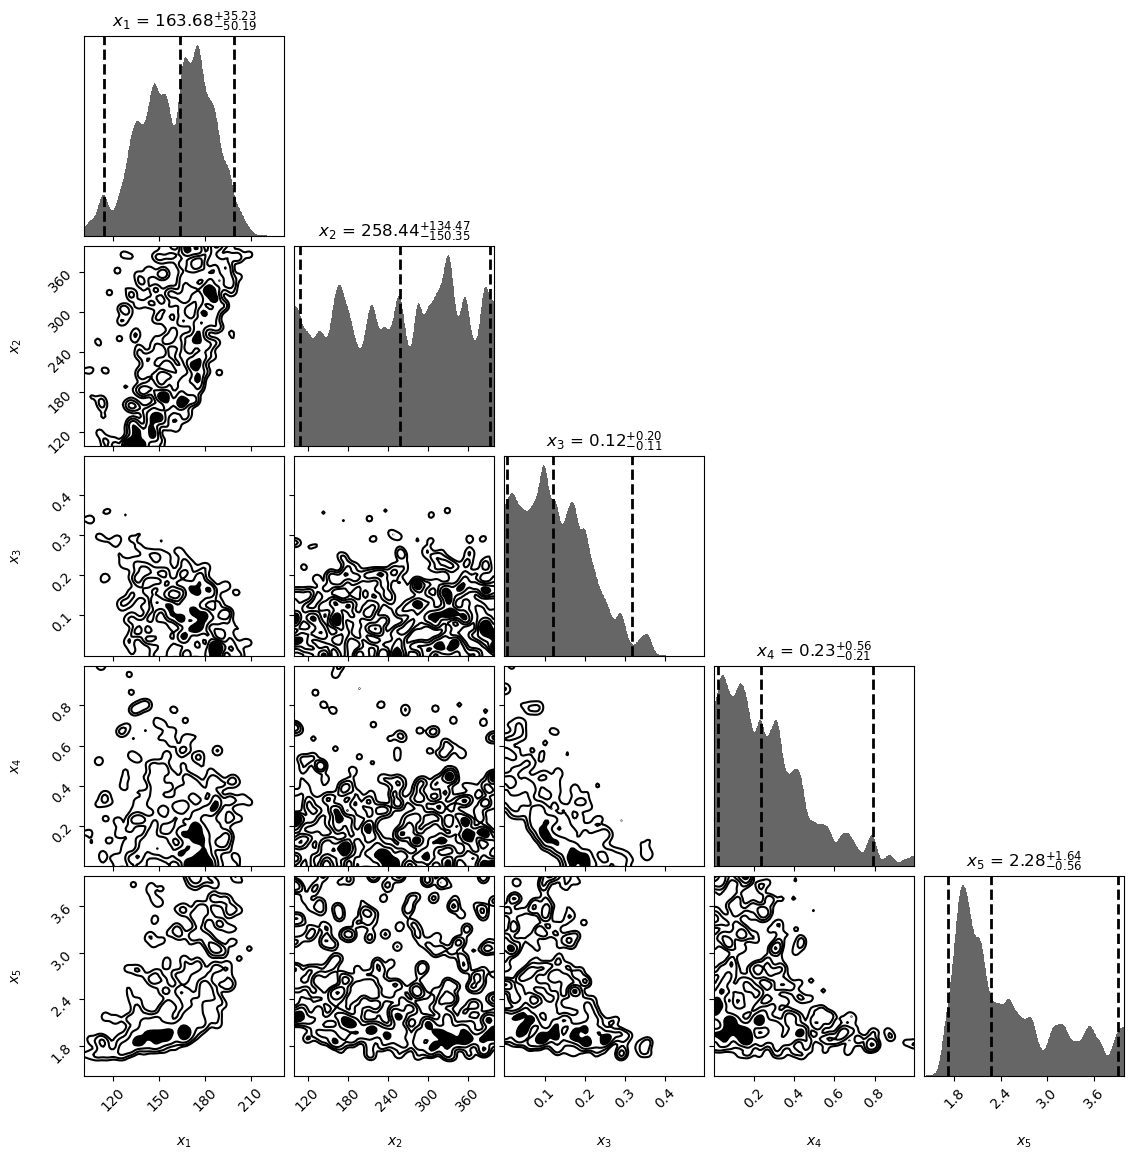

In [73]:
from dynesty import plotting as dyplot
import matplotlib.pyplot as plt

fig, axes = dyplot.cornerplot(results, 
                              show_titles=True, 
                              title_fmt=".2f")
plt.show()

In [430]:
best_fit = equal_samples.mean(axis=0)
print("Best-fit parameters:", best_fit)

# Or MAP-like point
max_logl_idx = np.argmax(results.logl)
print("Maximum likelihood parameters:", results.samples[max_logl_idx])

Best-fit parameters: [119.81380835  85.92098099]
Maximum likelihood parameters: [104.29331071  47.54977691]
